#### data preparation (conversion of DICOM PET/CT studies to nifti  format for running automated lesion segmentation)

In [2]:
import pathlib as plb
import tempfile
import os
import dicom2nifti
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import nilearn.image
import shutil
import pydicom
from nibabel.orientations import ornt_transform, axcodes2ornt, inv_ornt_aff, apply_orientation, io_orientation, aff2axcodes

In [18]:
# find all studies

def find_studies(path_to_data):
    dicom_root = plb.Path(path_to_data)
    patient_dirs = list(dicom_root.glob('*'))

    study_dirs = []

    for dir in patient_dirs:
        sub_dirs = list(dir.glob('*'))
        #print(sub_dirs)
        study_dirs.extend(sub_dirs)
        
        #dicom_dirs = dicom_dirs.append(dir.glob('*'))
    return study_dirs

In [19]:
# identify CT, PET and mask subfolders and return dicitionary of modalities and corresponding paths, also return series ID, output is a dictionary

def identify_modalities(study_dir):
    study_dir = plb.Path(study_dir)
    sub_dirs = list(study_dir.glob('*'))

    modalities = {}

    for dir in sub_dirs:
        first_file = next(dir.glob('*.dcm'))
        ds = pydicom.dcmread(str(first_file))
        #print(ds)
        modality = ds.Modality
        modalities[modality] = dir
    
    modalities["ID"] = ds.StudyInstanceUID
    return modalities       


In [20]:
#conversion of CT DICOM (in the CT_dcm_path) to nifti and save in nii_out_path

def dcm2nii_CT(CT_dcm_path, nii_out_path):

    with tempfile.TemporaryDirectory() as tmp: #convert CT
        tmp = plb.Path(str(tmp))
        # convert dicom directory to nifti
        # (store results in temp directory)
        dicom2nifti.convert_directory(CT_dcm_path, str(tmp), 
                                      compression=True, reorient=True)
        nii = next(tmp.glob('*nii.gz'))
        # copy niftis to output folder with consistent naming
        shutil.copy(nii, nii_out_path/'CT.nii.gz')

In [21]:
#conversion of PET DICOM (in the PET_dcm_path) to nifti (and SUV nifti) and save in nii_out_path

def dcm2nii_PET(PET_dcm_path, nii_out_path):

    first_pt_dcm = next(PET_dcm_path.glob('*.dcm'))
    suv_corr_factor = calculate_suv_factor(first_pt_dcm)

    with tempfile.TemporaryDirectory() as tmp: #convert PET
        tmp = plb.Path(str(tmp))
        # convert dicom directory to nifti
        # (store results in temp directory)
        dicom2nifti.convert_directory(PET_dcm_path, str(tmp), 
                                    compression=True, reorient=True)
        nii = next(tmp.glob('*nii.gz'))
        # copy nifti to output folder with consistent naming
        shutil.copy(nii, nii_out_path/'PET.nii.gz')

        # convert pet images to quantitative suv images and save nifti file
        suv_pet_nii = convert_pet(nib.load(nii_out_path/'PET.nii.gz'), suv_factor=suv_corr_factor)
        nib.save(suv_pet_nii, nii_out_path/'SUV.nii.gz')

In [22]:
# functions for conversion of PET values to SUV (should work on Siemens PET/CT)

def conv_time(time_str):
    return (float(time_str[:2]) * 3600 + float(time_str[2:4]) * 60 + float(time_str[4:13]))

def calculate_suv_factor(dcm_path): # reads a PET dicom file and calculates the SUV conversion factor
    ds = pydicom.dcmread(str(dcm_path))
    total_dose = ds.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose
    start_time = ds.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime
    half_life = ds.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife
    acq_time = ds.AcquisitionTime
    weight = ds.PatientWeight
    time_diff = conv_time(acq_time) - conv_time(start_time)
    act_dose = total_dose * 0.5 ** (time_diff / half_life)
    suv_factor = 1000 * weight / act_dose
    return suv_factor

def convert_pet(pet, suv_factor):
    affine = pet.affine
    pet_data = pet.get_fdata()
    pet_suv_data = (pet_data*suv_factor).astype(np.float32)
    pet_suv = nib.Nifti1Image(pet_suv_data, affine)
    return pet_suv

In [23]:
#conversion of the mask dicom file to nifti (not directly possible with dicom2nifti)
def dcm2nii_mask(mask_dcm_path, nii_out_path):

    mask_dcm = list(mask_dcm_path.glob('*.dcm'))[0]
    mask = pydicom.read_file(str(mask_dcm))
    mask_array = mask.pixel_array
    
    # get mask array to correct orientation (this procedure is dataset specific)
    mask_array = np.transpose(mask_array,(2,1,0) )  
    mask_orientation = mask[0x5200, 0x9229][0].PlaneOrientationSequence[0].ImageOrientationPatient
    if mask_orientation[4] == 1:
        mask_array = np.flip(mask_array, 1 )
    
    # get affine matrix from the corresponding pet             
    pet = nib.load(str(nii_out_path/'PET.nii.gz'))
    pet_affine = pet.affine
    
    # return mask as nifti object
    mask_out = nib.Nifti1Image(mask_array, pet_affine)
    nib.save(mask_out, nii_out_path/'Mask.nii.gz')    

In [24]:
     #resample CT to PET and mask resolution 
def resample_ct(nii_out_path):
    ct   = nib.load(nii_out_path/'CT.nii.gz')
    pet  = nib.load(nii_out_path/'PET.nii.gz')
    CTres = nilearn.image.resample_to_img(ct, pet, fill_value=-1024)
    nib.save(CTres, nii_out_path/'CTres.nii.gz')

In [25]:
path_to_data = '/mnt/data/datasets/TCIA_test/manifest-1645807661584/FDG-PET-CT-Lesions'
study_dirs = find_studies(path_to_data)

In [26]:
nii_out_root = plb.Path('/mnt/data/datasets/TCIA_test/nii/')

In [119]:
for study_dir in study_dirs:

    patient = study_dir.parent.name

    modalities = identify_modalities(study_dir)

    outpath_name = patient+'_'+modalities["ID"][-5:]

    nii_out_path = plb.Path(nii_out_root/outpath_name)
    
    os.makedirs(nii_out_path, exist_ok=True)
    
    print(["currently processing:", outpath_name])

    dcm2nii_CT(modalities["CT"], nii_out_path)

    dcm2nii_PET(modalities["PT"], nii_out_path)

    dcm2nii_mask(modalities["SEG"], nii_out_path)

    resample_ct(nii_out_path)  

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


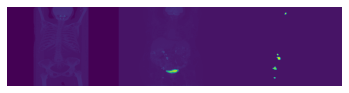

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


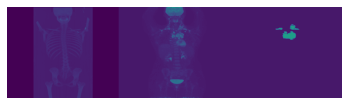

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


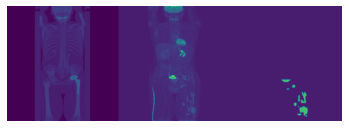

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


/home/ragatis1/miniconda3/envs/tcia/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


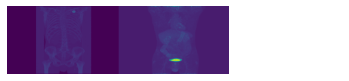

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


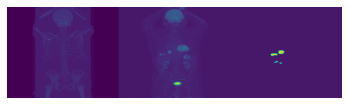

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


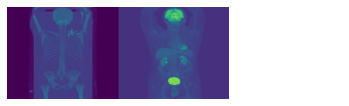

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


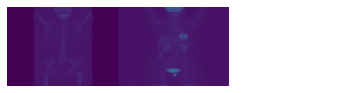

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


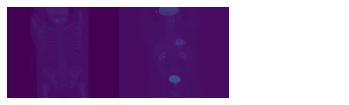

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


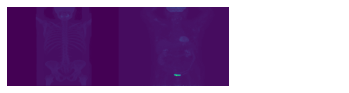

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


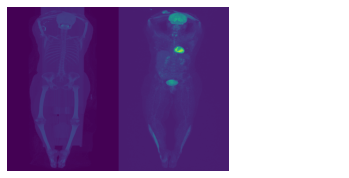

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


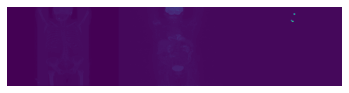

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


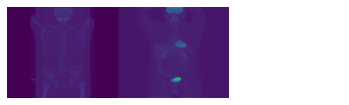

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


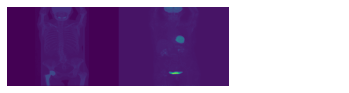

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


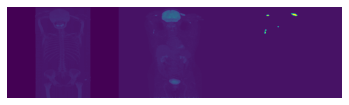

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


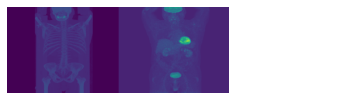

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


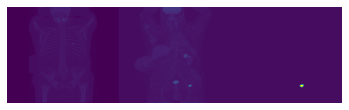

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


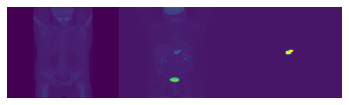

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


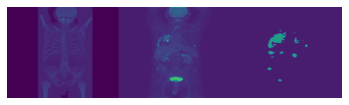

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


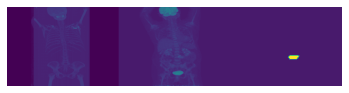

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


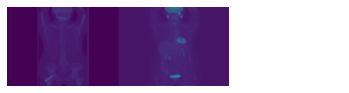

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


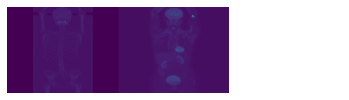

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


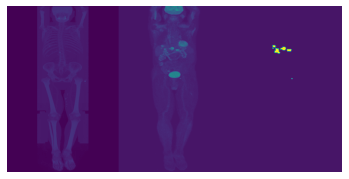

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


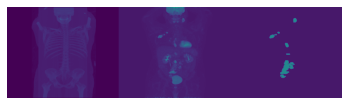

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


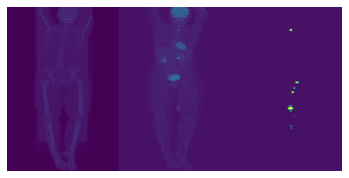

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


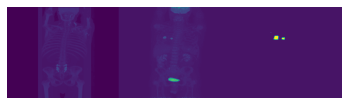

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


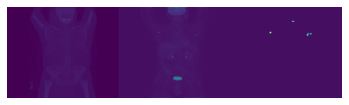

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


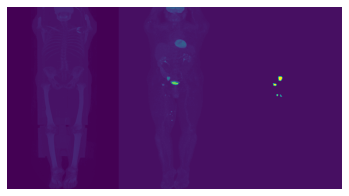

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


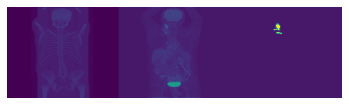

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


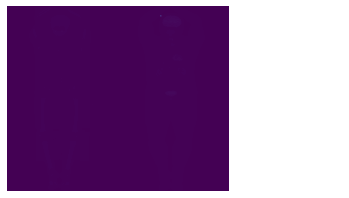

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


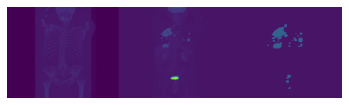

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


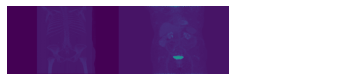

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


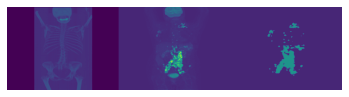

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


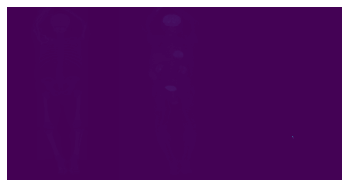

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


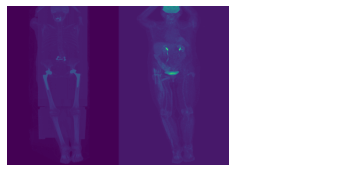

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


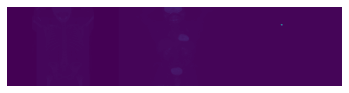

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


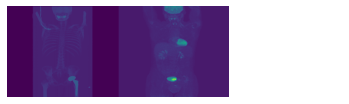

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


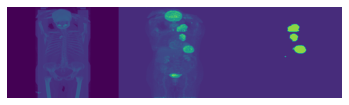

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


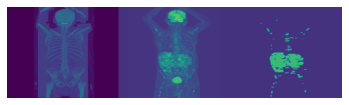

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


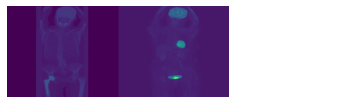

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


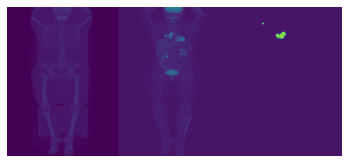

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


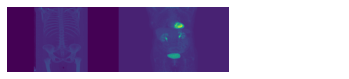

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


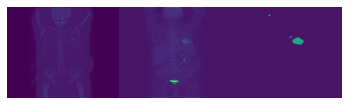

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


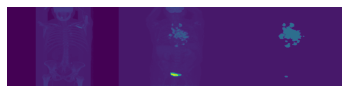

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


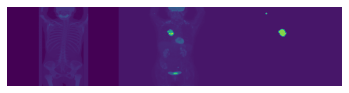

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


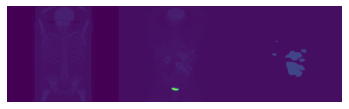

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


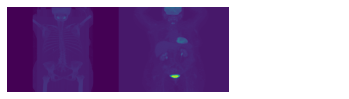

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


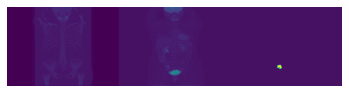

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


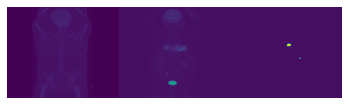

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


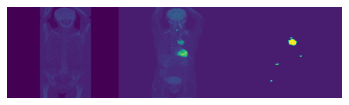

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


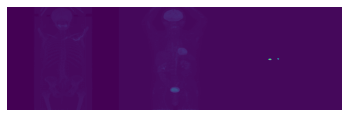

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


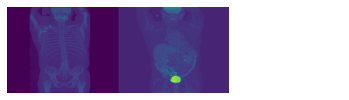

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


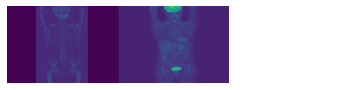

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


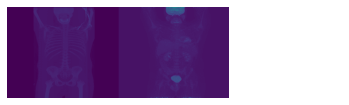

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


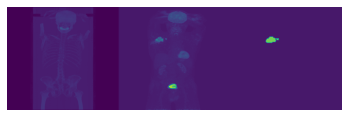

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


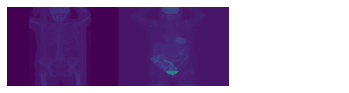

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


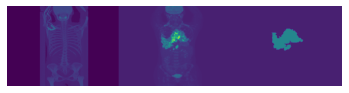

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


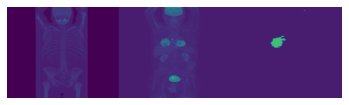

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


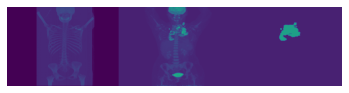

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


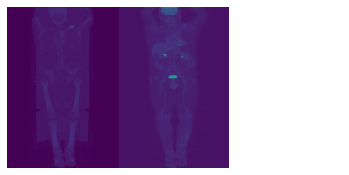

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


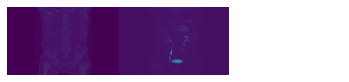

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


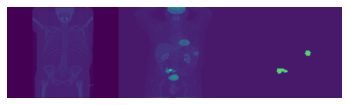

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


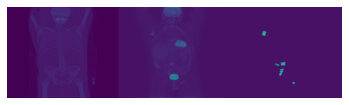

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


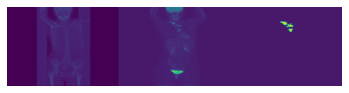

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


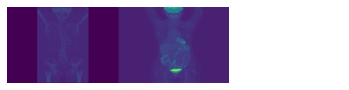

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


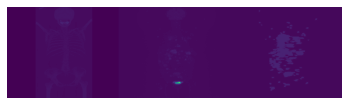

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


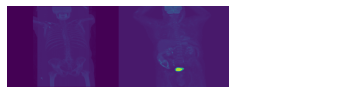

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


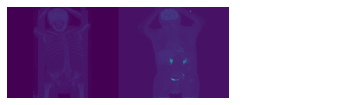

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


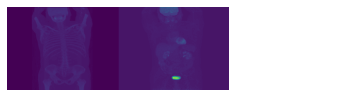

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


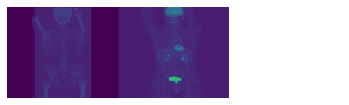

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


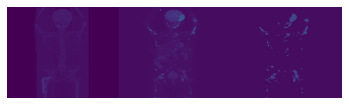

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


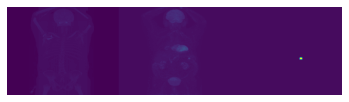

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


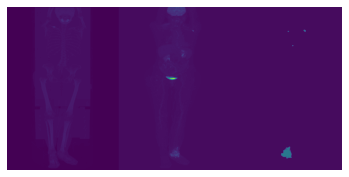

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


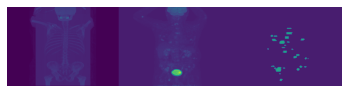

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


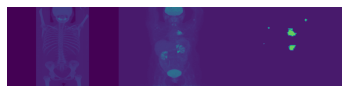

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


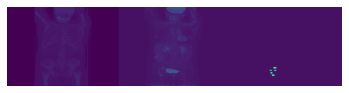

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


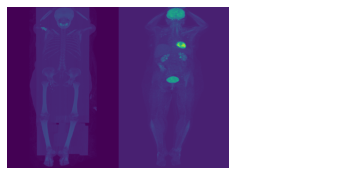

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


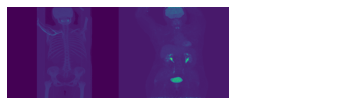

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


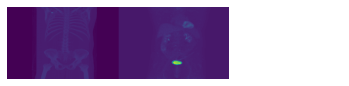

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


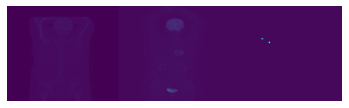

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


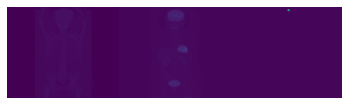

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


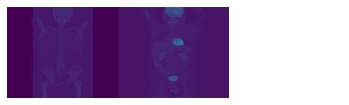

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


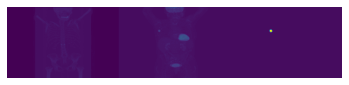

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


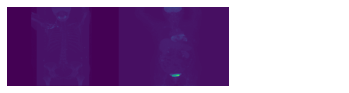

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


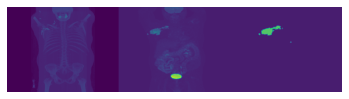

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


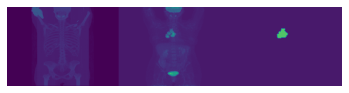

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


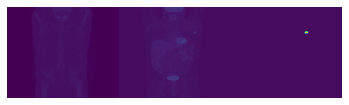

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


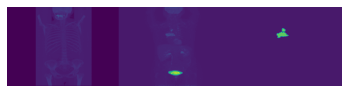

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


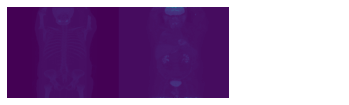

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


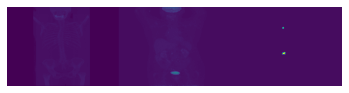

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


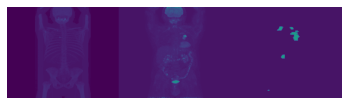

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


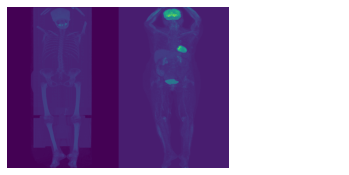

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


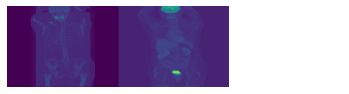

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


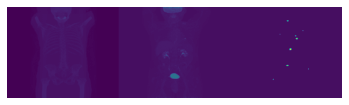

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


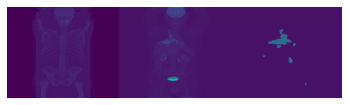

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


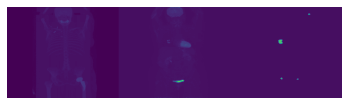

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


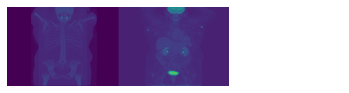

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


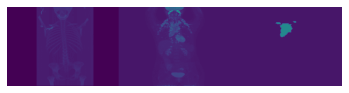

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


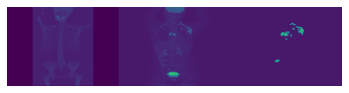

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


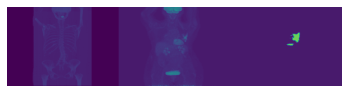

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


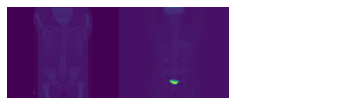

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


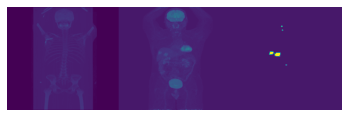

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


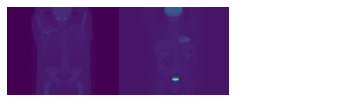

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


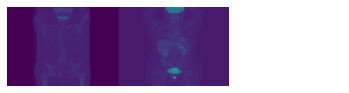

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


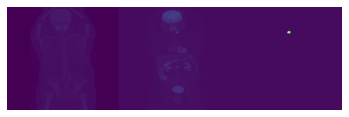

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


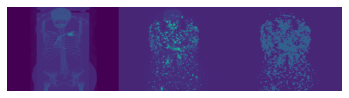

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


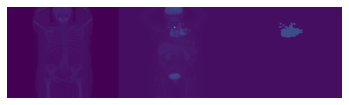

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


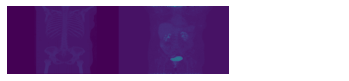

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


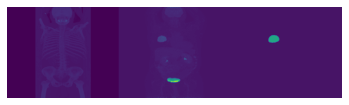

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


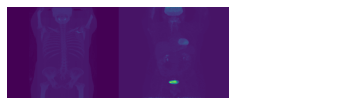

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


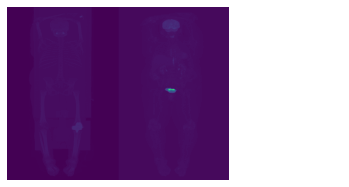

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


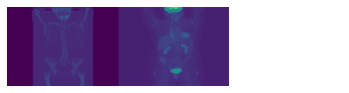

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


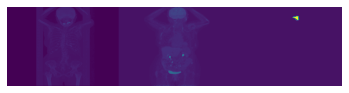

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


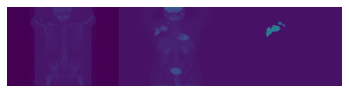

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


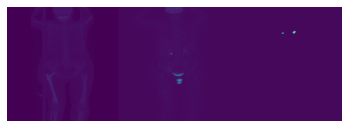

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


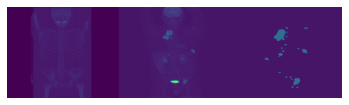

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


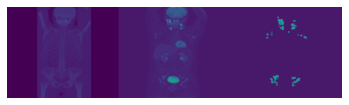

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


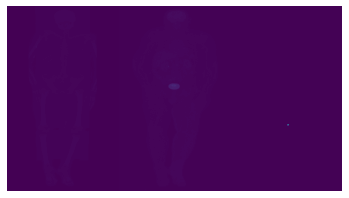

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


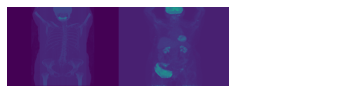

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


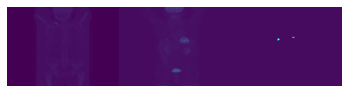

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


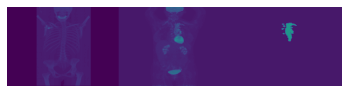

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


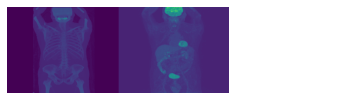

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


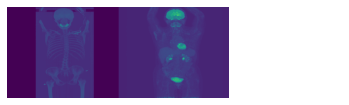

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


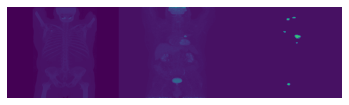

In [11]:
nii_out_root = plb.Path('/mnt/data/datasets/TCIA_test/nii/')
pat_dirs = list(nii_out_root.glob('*'))

for pat_dir in pat_dirs:
    suv = nib.load(str(pat_dir/'SUV.nii.gz'))
    ct  = nib.load(str(pat_dir/'CTres.nii.gz'))
    seg = nib.load(str(pat_dir/'Mask.nii.gz'))
    
    suv = suv.get_fdata()
    ct = ct.get_fdata()
    seg = seg.get_fdata()

    
    MIP_ct = np.amax(ct,1)
    #MIP_ct = np.flip(MIP_ct, 0) / np.linalg.norm(MIP_ct)
    MIP_ct = MIP_ct / np.linalg.norm(MIP_ct)
    
    MIP_pt = np.amax(suv,1)
    #MIP_pt = np.flip(MIP_pt, 0) / np.linalg.norm(MIP_pt)
    MIP_pt = MIP_pt / np.linalg.norm(MIP_pt)

    MIP_seg = np.amax(seg,1)
    #MIP_seg = np.flip(MIP_seg, 0) / np.linalg.norm(MIP_seg)
    MIP_seg = MIP_seg / np.linalg.norm(MIP_seg)

    print(type(MIP_ct),type(MIP_pt),type(MIP_seg))

    MIP_all = np.concatenate((MIP_ct,MIP_pt,MIP_seg))
    MIP_all = np.flip(MIP_all,1)
   
    plt.figure()
    plt.axis('off')
    plt.imshow(np.transpose(MIP_all))
    plt.show()
    
    #print(MIP.shape)
    #plt.savefig("D:\\Sergios\\PET_LIT\\PET_LIT_MIPs\\"+folder[0:-11]+'_fu1.png')
    #plt.savefig("D:\\Sergios\\PET_LIT\\PET_LIT_MIPs\\"+folder[0:-11])
  

    



In [4]:
nii_out_root = plb.Path('/mnt/data/datasets/TCIA_test/nii/')
pat_dirs = list(nii_out_root.glob('*'))

In [5]:
pat_dirs

[PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_119165872d_05102'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_0b57b247b6_42966'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_05808cf24e_42289'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_17b46d7275_01963'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_1a1712f7d0_51804'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_1cb2d26a19_70937'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_0410759456_75415'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_1bdefef7d5_32502'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_07b7e9abfc_08717'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_07fec0d985_11312'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_11afab3485_50146'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_0e9a98ecda_36915'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_234f8427c0_25891'),
 PosixPath('/mnt/data/datasets/TCIA_test/nii/PETCT_0011f3deaf_10445'),
 Posix